LSTM 기반의 삼성전자 주가 예측 예제
 - yahoo finance 에서 데이터 다운로드 후 3일(3MA), 5일(5MA) 가격이평선 추가

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

데이터 불러오기

In [2]:
raw_df = pd.read_csv('./005930.KS_3MA_5MA.csv')  # yahoo finance 로부터 데이터 다운로드

raw_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
0,2000-01-04,6000.0,6110.0,5660.0,6110.0,4740.119629,74195000.0,NaN,NaN
1,2000-01-05,5800.0,6060.0,5520.0,5580.0,4328.947754,74680000.0,NaN,NaN
2,2000-01-06,5750.0,5780.0,5580.0,5620.0,4359.979492,54390000.0,4476.348958,NaN
3,2000-01-07,5560.0,5670.0,5360.0,5540.0,4297.916992,40305000.0,4328.948079,NaN
4,2000-01-10,5600.0,5770.0,5580.0,5770.0,4476.349121,46880000.0,4378.081868,4440.662598


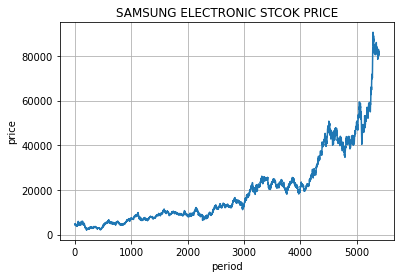

In [3]:
plt.title('SAMSUNG ELECTRONIC STCOK PRICE')
plt.ylabel('price')
plt.xlabel('period')
plt.grid()

plt.plot(raw_df['Adj Close'], label='Adj Close')

plt.show()

데이터 전처리 (Missing Data 처리, 정규화 등)

In [4]:
# 통계정보 확인

raw_df.describe()

,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
count,5389.000000,5389.000000,5389.000000,5389.000000,5389.000000,5.389000e+03,5393.000000,5391.000000
mean,22801.887178,23043.991464,22559.285582,22801.909445,19920.044863,2.207838e+07,19934.224878,19925.585966
std,17736.201238,17906.827402,17572.109940,17733.296811,17322.636387,1.564053e+07,17313.297249,17292.697383
min,2540.000000,2760.000000,2420.000000,2730.000000,2117.926025,0.000000e+00,2164.473877,2179.989746
25%,9880.000000,9990.000000,9800.000000,9900.000000,7726.937988,1.185265e+07,7726.939453,7709.871631
50%,15760.000000,15940.000000,15560.000000,15800.000000,12808.596680,1.803935e+07,12802.806970,12809.314840
75%,29280.000000,29560.000000,29000.000000,29280.000000,24566.556640,2.771475e+07,24558.166020,24555.269140
max,90300.000000,96800.000000,89500.000000,91000.000000,90597.414060,1.642150e+08,90033.252600,89562.014060


In [10]:
# Missing Data 확인

raw_df.isnull().sum()

Date         0
Open         6
High         6
Low          6
Close        6
Adj Close    6
Volume       6
3MA          2
5MA          4
dtype: int64

In [11]:
# 최소값이 0 인 column 체크

for col in raw_df.columns:

    if raw_df[col].min() == 0:
        col_name = col
        print(col_name, type(col_name))

Volume <class 'str'>


In [12]:
raw_df.loc[raw_df['Volume']==0]

,Date,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
23,2000-02-04,5130.0,5130.0,5130.0,5130.0,3979.839355,0.0,4010.871419,4097.760644
41,2000-03-01,5120.0,5120.0,5120.0,5120.0,3972.081543,0.0,3889.329834,3914.672510
66,2000-04-05,6800.0,6800.0,6800.0,6800.0,5275.420410,0.0,5353.000163,5345.242773
72,2000-04-13,6910.0,6910.0,6910.0,6910.0,5360.757324,0.0,5409.891439,5495.746680
84,2000-05-01,6000.0,6000.0,6000.0,6000.0,4654.781250,0.0,4499.622070,4443.765039
...,...,...,...,...,...,...,...,...,...
4623,2018-04-30,53000.0,53000.0,53000.0,53000.0,47819.117190,0.0,47560.473960,46736.421880
4624,2018-05-02,53000.0,53000.0,53000.0,53000.0,47819.117190,0.0,47819.117190,47194.763280
4625,2018-05-03,53000.0,53000.0,53000.0,53000.0,47819.117190,0.0,47819.117190,47663.931250
5077,2020-03-09,56500.0,56500.0,56500.0,56500.0,53774.468750,0.0,54186.897140,53983.855470


In [13]:
# 각 column에 0 몇개인지 확인

for col in raw_df.columns:

    missing_rows = raw_df.loc[raw_df[col]==0].shape[0]
    print(col + ': ' + str(missing_rows))

Date: 0
Open: 0
High: 0
Low: 0
Close: 0
Adj Close: 0
Volume: 116
3MA: 0
5MA: 0


In [14]:
# 먼저 0 을 NaN 으로 바꾼후, Missing Data 처리

raw_df['Volume'] = raw_df['Volume'].replace(0, np.nan)

# 각 column에 0 몇개인지 확인

for col in raw_df.columns:

    missing_rows = raw_df.loc[raw_df[col]==0].shape[0]
    print(col + ': ' + str(missing_rows))

Date: 0
Open: 0
High: 0
Low: 0
Close: 0
Adj Close: 0
Volume: 0
3MA: 0
5MA: 0


In [15]:
# missing data 확인

raw_df.isnull().sum()

Date           0
Open           6
High           6
Low            6
Close          6
Adj Close      6
Volume       122
3MA            2
5MA            4
dtype: int64

In [16]:
raw_df.isnull().any()

Date         False
Open          True
High          True
Low           True
Close         True
Adj Close     True
Volume        True
3MA           True
5MA           True
dtype: bool

In [17]:
raw_df.loc[raw_df['Open'].isna()]

,Date,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
1304,2005-01-03,NaN,NaN,NaN,NaN,NaN,NaN,6989.931152,6910.412353
4513,2017-11-16,NaN,NaN,NaN,NaN,NaN,NaN,49382.673830,49719.997070
4518,2017-11-23,NaN,NaN,NaN,NaN,NaN,NaN,49373.792970,49324.969730
4542,2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN,44927.763670,44190.302730
4755,2018-11-15,NaN,NaN,NaN,NaN,NaN,NaN,40569.835940,40775.886720
5000,2019-11-14,NaN,NaN,NaN,NaN,NaN,NaN,49695.419920,49364.432620


In [18]:
# missing data 처리

raw_df = raw_df.dropna()

raw_df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
3MA          0
5MA          0
dtype: int64

In [19]:
# 정규화 (Date 제외한 모든 수치부분 정규화)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scale_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close',
              '3MA', '5MA', 'Volume']

scaled_df = scaler.fit_transform(raw_df[scale_cols])

scaled_df = pd.DataFrame(scaled_df, columns=scale_cols)

print(scaled_df)

          Open      High       Low  ...       3MA       5MA    Volume
0     0.034868  0.032008  0.036288  ...  0.025192  0.025698  0.285359
1     0.037375  0.035517  0.038470  ...  0.025634  0.025094  0.363715
2     0.034982  0.031689  0.036518  ...  0.026163  0.025343  0.177799
3     0.034868  0.031689  0.036059  ...  0.025987  0.025503  0.250704
4     0.036235  0.033177  0.037437  ...  0.026163  0.026018  0.300555
...        ...       ...       ...  ...       ...       ...       ...
5264  0.891750  0.830923  0.896647  ...  0.895299  0.903144  0.064088
5265  0.892890  0.834113  0.897795  ...  0.894920  0.900854  0.061199
5266  0.899727  0.841557  0.903537  ...  0.897955  0.902457  0.091190
5267  0.895169  0.835177  0.898944  ...  0.899472  0.902228  0.085145
5268  0.895169  0.833050  0.896647  ...  0.897955  0.901083  0.090683

[5269 rows x 8 columns]


주가예측을 위해 3MA, 5MA, Adj Close 항목을 feature 선정
 - 정답은 Adj Close 선정
 - 시계열 데이터를 위한 window_size = 40 선정

In [24]:
# 입력 파라미터 feature, label => numpy type

def make_sequene_dataset(feature, label, window_size):

    feature_list = []      # 생성될 feature list
    label_list = []        # 생성될 label list

    for i in range(len(feature)-window_size):

        feature_list.append(feature[i:i+window_size])
        label_list.append(label[i+window_size])

    return np.array(feature_list), np.array(label_list)

In [70]:
# feature_df, label_df 생성

feature_cols = [ '3MA', '5MA', 'Adj Close' ]
label_cols = [ 'Adj Close' ]

feature_df = pd.DataFrame(scaled_df, columns=feature_cols)
label_df = pd.DataFrame(scaled_df, columns=label_cols)

In [71]:
# DataFrame => Numpy 변환

feature_np = feature_df.to_numpy()
label_np = label_df.to_numpy()

print(feature_np.shape, label_np.shape)

(5269, 3) (5269, 1)


시계열 데이터 생성 (make_sequence_dataset)

In [72]:
window_size = 40

X, Y = make_sequene_dataset(feature_np, label_np, window_size)

print(X.shape, Y.shape)

(5229, 40, 3) (5229, 1)


학습데이터, 테스트데이터 생성

In [73]:
# train, test 분리

#split = int(len(X)*0.95)
split = -200

x_train = X[0:split]
y_train = Y[0:split]

x_test = X[split:]
y_test = Y[split:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5029, 40, 3) (5029, 1)
(200, 40, 3) (200, 1)


모델 구축 및 컴파일

In [74]:
# model 생성

model = Sequential()

model.add(LSTM(128, activation='tanh', input_shape=x_train[0].shape))

model.add(Dense(1, activation='linear'))

In [75]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 128)               67584     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 67,713
Trainable params: 67,713
Non-trainable params: 0
_________________________________________________________________


모델 학습 (EarlyStopping 적용)

In [76]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          epochs=100, batch_size=16,
          callbacks=[early_stop])

Epoch 1/100
315/315 [==============================] - 3s 5ms/step - loss: 8.4391e-04 - mae: 0.0115 - val_loss: 8.1629e-04 - val_mae: 0.0191
Epoch 2/100
315/315 [==============================] - 1s 4ms/step - loss: 9.1896e-05 - mae: 0.0062 - val_loss: 6.6948e-04 - val_mae: 0.0182
Epoch 3/100
315/315 [==============================] - 1s 4ms/step - loss: 7.8710e-05 - mae: 0.0058 - val_loss: 6.0811e-04 - val_mae: 0.0168
Epoch 4/100
315/315 [==============================] - 1s 4ms/step - loss: 7.3097e-05 - mae: 0.0057 - val_loss: 4.9352e-04 - val_mae: 0.0161
Epoch 5/100
315/315 [==============================] - 1s 4ms/step - loss: 7.0582e-05 - mae: 0.0055 - val_loss: 4.7144e-04 - val_mae: 0.0151
Epoch 6/100
315/315 [==============================] - 1s 4ms/step - loss: 6.2219e-05 - mae: 0.0052 - val_loss: 9.7192e-04 - val_mae: 0.0254
Epoch 7/100
315/315 [==============================] - 1s 4ms/step - loss: 6.2817e-05 - mae: 0.0052 - val_loss: 3.5413e-04 - val_mae: 0.0140
Epoch 8/100
3

예측을 통한 정답과의 비교 
(오차계산 MAPE 사용, 평균절대값백분율오차)

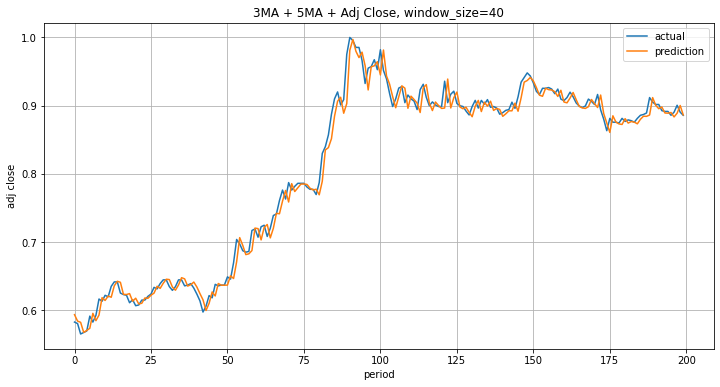

In [77]:
pred = model.predict(x_test)

plt.figure(figsize=(12, 6))
plt.title('3MA + 5MA + Adj Close, window_size=40')
plt.ylabel('adj close')
plt.xlabel('period')
plt.plot(y_test, label='actual')
plt.plot(pred, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()

In [78]:
# 평균절대값백분율오차계산 (MAPE)

print( np.sum(abs(y_test-pred)/y_test) / len(x_test) )

0.01224175273632353
